In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)

In [2]:
# ---------------------------------------------------------
df = pd.read_csv("malicious_phish.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (453658, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
X = df.drop("type", axis=1)
y = df["type"]

# Encode target if needed (malicious/safe → 0/1)
y = y.astype('category').cat.codes

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
from sklearn.preprocessing import StandardScaler

def extract_url_features(df_urls):
    # Ensure we're working with a copy to avoid SettingWithCopyWarning
    df_urls_copy = df_urls.copy()
    # Extract numerical features from the 'url' column
    df_urls_copy['url_length'] = df_urls_copy['url'].apply(len)
    df_urls_copy['num_dots'] = df_urls_copy['url'].apply(lambda x: x.count('.'))
    # Add more features as needed, e.g., number of hyphens, digits, etc.
    df_urls_copy['num_hyphens'] = df_urls_copy['url'].apply(lambda x: x.count('-'))
    df_urls_copy['num_digits'] = df_urls_copy['url'].apply(lambda x: sum(c.isdigit() for c in x))
    df_urls_copy['has_http'] = df_urls_copy['url'].apply(lambda x: 1 if 'http' in x else 0)
    df_urls_copy['has_https'] = df_urls_copy['url'].apply(lambda x: 1 if 'https' in x else 0)
    df_urls_copy['has_www'] = df_urls_copy['url'].apply(lambda x: 1 if 'www' in x else 0)
    df_urls_copy['has_at_symbol'] = df_urls_copy['url'].apply(lambda x: 1 if '@' in x else 0)
    df_urls_copy['has_redirect'] = df_urls_copy['url'].apply(lambda x: 1 if '//' in x and x.index('//') != x.rfind('//') else 0)
    df_urls_copy['segment_count'] = df_urls_copy['url'].apply(lambda x: len(x.split('/')))
    # Drop the original 'url' column as it's now represented by numerical features
    return df_urls_copy.drop('url', axis=1)

# Apply feature extraction to X_train and X_test
X_train_processed = extract_url_features(X_train)
X_test_processed = extract_url_features(X_test)

# Initialize and apply StandardScaler to the processed numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

In [9]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

rf.fit(X_train_scaled, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [10]:
# 7. Predictions
# ---------------------------------------------------------
y_pred = rf.predict(X_test_scaled)

In [11]:
# ---------------------------------------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9864105277079751

Confusion Matrix:
 [[    0     0     0     0     1]
 [    0 66074   105    39    15]
 [    0   133 16570    67   149]
 [    0    50    56  1872   154]
 [    0    45   396    23  4983]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       1.00      1.00      1.00     66233
           1       0.97      0.98      0.97     16919
           2       0.94      0.88      0.91      2132
           3       0.94      0.91      0.93      5447

    accuracy                           0.99     90732
   macro avg       0.77      0.75      0.76     90732
weighted avg       0.99      0.99      0.99     90732



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


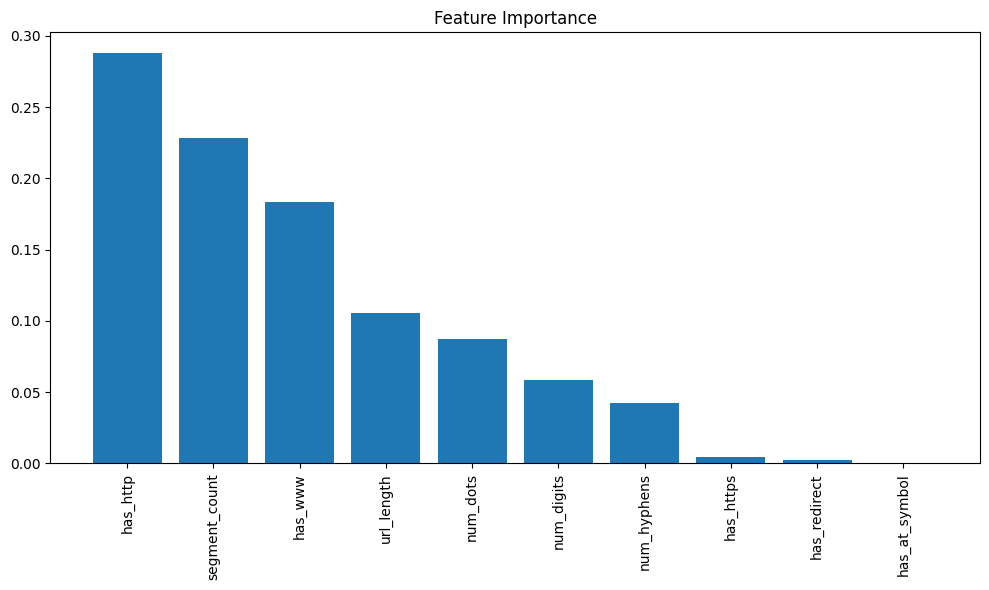

In [13]:
# 9. Feature Importance
# ---------------------------------------------------------
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X_train_processed.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

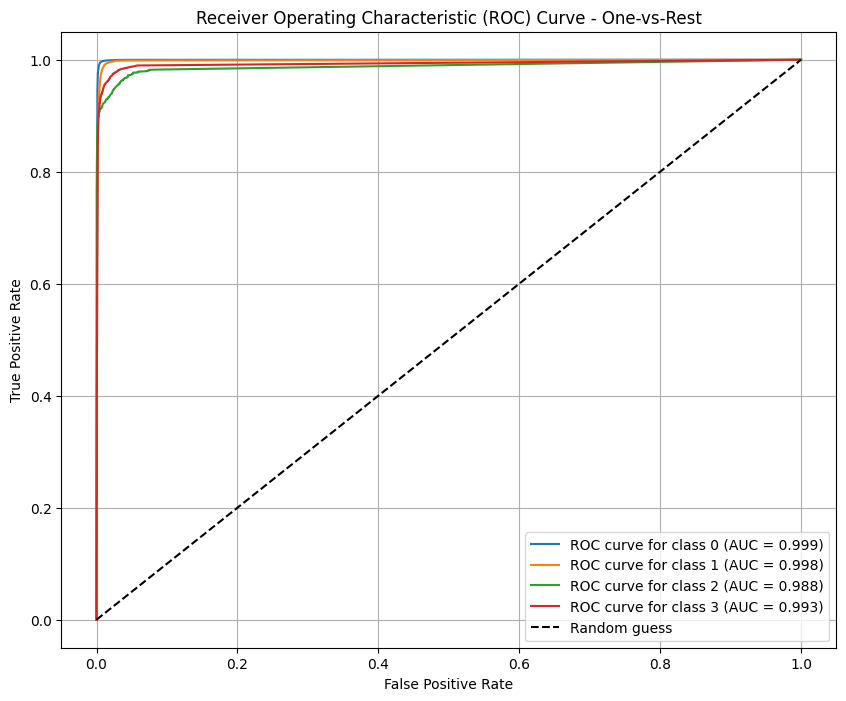

In [16]:
# 10. ROC Curve & AUC Score
# ---------------------------------------------------------
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities for all classes
y_pred_proba = rf.predict_proba(X_test_scaled)

# Get unique class labels from y_test and sort them
unique_classes = np.sort(y_test.unique())

# Plot ROC curve for each class (One-vs-Rest approach)
plt.figure(figsize=(10, 8))

# Iterate over the classes known by the Random Forest classifier
# This ensures that class_label is always in rf.classes_ and
# the index 'i' correctly maps to the column in y_pred_proba
for i, class_label in enumerate(rf.classes_):
    # Create a binary target for the current class (1 if it's the class, 0 otherwise)
    y_test_binary = (y_test == class_label).astype(int)

    # Get the probabilities for the current class.
    # 'i' is the column index corresponding to 'class_label' in y_pred_proba
    y_prob_class = y_pred_proba[:, i]

    # Compute ROC values
    fpr, tpr, _ = roc_curve(y_test_binary, y_prob_class)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve for class {class_label} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess') # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.grid()
plt.show()